## 1. 线性回归
线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和：
$$
\hat{y} = w_1 x_1 + w_2 x_2 + b
$$
其中，$\hat{y}$ 是预测的房屋价格，$x_1$ 和 $x_2$ 是面积和房龄特征，$w_1$ 和 $w_2$ 是权重参数，$b$ 是偏置项。

我们有一堆真实的房屋数据（面积、房龄、真实价格）。我们用上面的公式去猜价格，肯定会和真实价格有差距。

损失函数，就是用来量化这个差距有多糟糕的尺子。最常用的尺子是平方误差：
$$
L(\hat{y}, y) = (\hat{y} - y)^2
$$
其中，$\hat{y}$ 是预测价格，$y$ 是真实价格。

我们的目标是找到一组最优的权重参数 $w_1, w_2, b$，使得所有训练样本的损失函数值的平均值最小。
$$
L(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n L(\hat{y}_i, y_i)
$$
其中，$n$ 是训练样本数量，$\hat{y}_i$ 是第 $i$ 个样本的预测价格，$y_i$ 是第 $i$ 个样本的真实价格。

怎么调整 w 和 b 才能让损失最小呢？有两种主要思路：
- 解析解（closed-form solution）
  - 做不到，太麻烦了
- 梯度下降（gradient descent），常用的随机梯度下降（stochastic gradient descent）
  a. 随机初始化：先随便猜一组 w 和 b（比如都设成0或很小的随机数）。
  b. 看方向（算梯度）：计算一下当前参数下，损失函数在往哪个方向走会下降最快？这个方向就是“梯度”的反方向。
    - 若$dL/dw > 0$（梯度为正）：要让w变小（反方向），才能让$L(w)$下降；
    - 若$dL/dw < 0$（梯度为负）：要让w变大（反方向），才能让$L(w)$下降。
  c. 迈一小步（更新参数）：沿着能让损失下降的方向，把 w 和 b 调整一点点。这一步的大小叫做学习率。
  d. 重复：用新参数，再重复b和c步。每次都看方向，迈一小步。

以损失函数$L(w) = (w-5)²$（这是一个开口向上的抛物线，最小值在$w=5$）为例：
梯度$dL/dw = 2*(w-5)$
- 当$w=8$时，梯度 = 2*(8-5)=6（正数）→ 说明w变大，$L(w)$会更糟；所以要让w变小（往梯度反方向走），比如$w = 8 - lr*6$；
- 当$w=2$时，梯度 = 2*(2-5)=-6（负数）→ 说明w变大，$L(w)$会变好；所以要让w变大（还是往梯度反方向走），比如$w = 2 - lr*(-6) = 2 + lr*6$。

不管梯度是正还是负，更新参数的公式都是：新 w = 旧 w - 学习率 × 梯度—— 这里的减号，就是 “梯度的反方向” 的体现

当我们通过上面的方法，找到了一组让我们“损失最小”、也就是“预测最准”的 w 和 b 之后，这个模型就“学成了”。

这时，给你一套新的、没见过的房子（知道面积和房龄），你就能用我们学到的那个公式：
【预测价格】 = 【新面积】 × w₁ + 【新房龄】 × w₂ + b
来给它估个价了！这个过程就叫预测或推断。

In [ ]:
import torch
import time

# 创建两个全1的向量
n = 10000
a = torch.ones(n)  # [1, 1, 1, ..., 1]（共10000个元素）
b = torch.ones(n)  # [1, 1, 1, ..., 1]

# 方法1: for循环（逐元素相加）
c = torch.zeros(n)  # 准备空结果向量
# 正确的计时方式：用time.time()记录开始/结束时间
start_time = time.time()
for i in range(n):          
    c[i] = a[i] + b[i]     
end_time = time.time()
loop_time = end_time - start_time
print(f'循环用时：{loop_time:.5f} 秒')

# 方法2: 矢量化（批量并行相加）
start_time = time.time()
d = a + b  # PyTorch底层并行处理所有元素的加法
end_time = time.time()
vectorized_time = end_time - start_time
print(f'矢量化用时：{vectorized_time:.5f} 秒')

# 验证两种方法结果一致（可选）
print(f'结果是否一致：{torch.allclose(c, d)}')  # 输出 True

循环用时：0.06515 秒
矢量化用时：0.00000 秒
结果是否一致：True


### 1.1 正态分布与平方损失
为什么偏偏选“平方误差”作为损失函数？而不是绝对值误差或其他？

我们承认，房价不可能完全由面积和房龄决定。还有无数其他因素：装修、学区、邻居、甚至卖家的心情...这些无法被模型捕捉的因素，我们统称为噪声。

一般而言，预设这个噪声为正态分布总不会错

1. 假设：真实值 y 等于预测值 ŷ 加上一个服从正态分布的噪声 ε。
y = ŷ + ε，其中 ε ~ N(0, σ²)
2. 翻译：根据正态分布的概率密度函数 (PDF),给定特征 x，观察到房价为 y 的概率是：
  
$$ P(y|x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y - \hat{y})^2}{2\sigma^2} \right) $$
> 当你的预测 ŷ 离真实值 y 越远，这个概率就越小
1. 最大似然估计(Max Likelihood Estimation, MLE)：我们想找到一组参数 w, b，使得整个数据集（包含 $n$ 个独立样本）出现的概率最大。这就需要将所有样本的概率相乘（联合概率）：

$$ L(w, b) = \prod_{i=1}^{n} P(y^{(i)} | x^{(i)}) $$

$$ L(w, b) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y^{(i)} - \hat{y}^{(i)})^2}{2\sigma^2} \right) $$
4. 取对数，变损失：
连乘运算在数学上很难处理，取对数变成求和：Σ log(P(y⁽ⁱ⁾|x⁽ⁱ⁾))

我们要**最大化**似然函数 $\ln L$，等价于**最小化**负对数似然 $-\ln L$。
同时，由于 $\sigma$ 是常数（噪声的方差），我们可以忽略常数项（不影响求极值的位置），只关注与误差有关的项：
$$ \text{Loss} = -\ln L(w, b) \propto \sum_{i=1}^{n} \left[ \frac{(y^{(i)} - \hat{y}^{(i)})^2}{2\sigma^2} \right] $$

去掉常数系数 $\frac{1}{2\sigma^2}$（因为乘以常数不改变函数的最小值点位置），最终得到的损失函数为：

$$ \text{Loss} = \sum_{i=1}^{n} (y^{(i)} - \hat{y}^{(i)})^2 $$

也即是说，**最小化平方误差**在数学上等价于**在噪声服从正态分布的假设下，最大化观测数据出现的概率**

## 2. 回归（最小）
### 2.1 生成数据集
y = 2x1 - 3.4x2 + 4.2

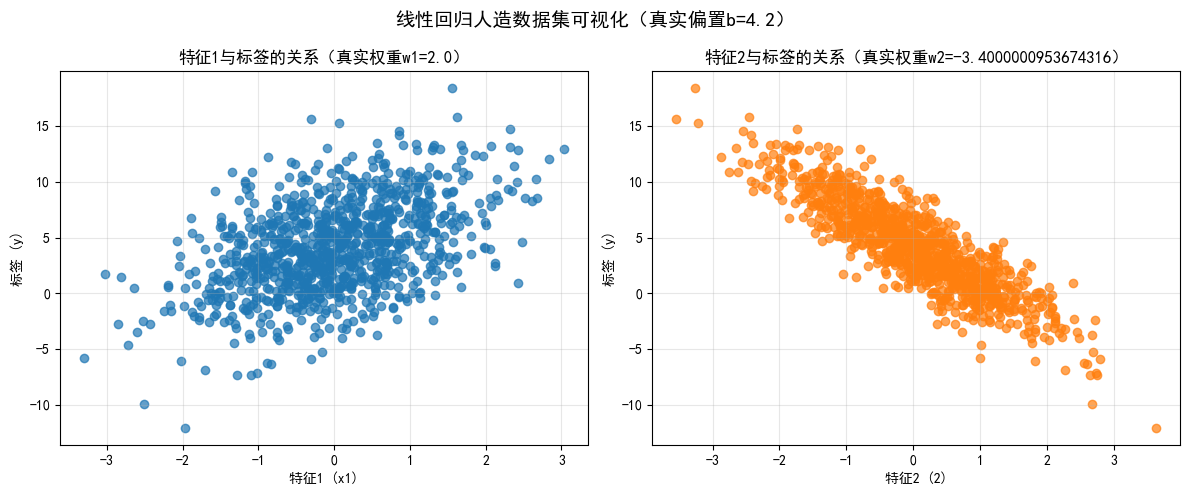

In [9]:
import random
import torch

def synthetic(w, b, num_eg):
    """生成y=Xw+b+噪声：模拟线性回归的人造数据集"""
    # 1. 生成特征X
    X = torch.normal(0, 1, (num_eg, len(w)))  # 特征：num_eg个样本，每个样本有len(w)个特征
    # 2. 计算真实标签（无噪声）
    y = torch.matmul(X, w) + b                # 严格的线性关系：y = X*w + b
    # 3. 加入微小噪声（模拟真实世界的误差）
    y += torch.normal(0, 0.01, y.shape)       # 噪声：均值0，标准差0.01，和y形状一致
    # 4. 返回特征和标签（标签转成列向量）
    return X, y.reshape((-1, 1))              # y的形状从(num_eg,)变成(num_eg, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic(true_w, true_b, 1000)
# print(f"features: {features}")  # features中的每一行都包含一个二维数据样本
# print(f"labels: {labels}")      # labels中的每一行都包含一维标签值（一个标量）
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
# 创建2个子图，分别展示特征1、特征2与标签的关系
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# 子图1：特征1（X[:,0]） vs 标签y
ax1.scatter(features[:, 0].numpy(), labels.numpy(), alpha=0.7, color="#1f77b4")
ax1.set_xlabel("特征1 (x1)")
ax1.set_ylabel("标签 (y)")
ax1.set_title(f"特征1与标签的关系（真实权重w1={true_w[0]}）")
ax1.grid(True, alpha=0.3)
# 子图2：特征2（X[:,1]） vs 标签y
ax2.scatter(features[:, 1].numpy(), labels.numpy(), alpha=0.7, color="#ff7f0e")
ax2.set_xlabel("特征2 (2)")
ax2.set_ylabel("标签 (y)")
ax2.set_title(f"特征2与标签的关系（真实权重w2={true_w[1]}）")
ax2.grid(True, alpha=0.3)
fig.suptitle(f"线性回归人造数据集可视化（真实偏置b={true_b}）", fontsize=14)
plt.tight_layout()
plt.show()



### 2.2 读取数据集

In [12]:
def data_iter(batch_size, features, labels):
    # 步骤1：获取总样本数
    num_examples = len(features)  # 比如100个样本，num_examples=100
    # 步骤2：生成样本索引列表（0到num_examples-1）
    indices = list(range(num_examples))  # 比如[0,1,2,...,99]
    # 步骤3：随机打乱索引（核心！保证每批数据是随机的）
    random.shuffle(indices)  # 打乱后可能变成[56, 8, 91, ..., 7]
    
    # 步骤4：按批次遍历打乱后的索引
    # range(0, num_examples, batch_size)：从0开始，每次跳batch_size步
    # 比如batch_size=32，遍历0→32→64→96
    for i in range(0, num_examples, batch_size):
        # 步骤5：取当前批次的索引（处理最后一批不足batch_size的情况）
        # min(i+batch_size, num_examples)：避免索引越界
        # 比如最后一批i=96，i+32=128>100，所以取到100
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        
        # 步骤6：yield返回当前批次的特征和标签（函数暂停，下次继续）
        yield features[batch_indices], labels[batch_indices]
        # 这里还有一个迭代器生成器的知识，很简单略过了
batch_size = 10

In [ ]:
# Pytorch 读取数据集当然要用 DataLoader 这样的高级封装
from torch.utils import data  # 数据加载器

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    # 等价于 data.TensorDataset(features, labels)
    # \*在这里的作用是解包可迭代对象（比如元组、列表）
    # 具体而言是把(features, labels)这个元组 “拆开来”，传给TensorDataset作为两个独立参数
    # TensorDataset作为样本打包器，把多个张量（比如特征 X、标签 y）按 “行” 打包成一个数据集
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
    # DataLoader自动完成 “打乱索引→按批次取样本→返回批次数据” 的全流程



### 2.3 初始化模型参数&定义模型

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重
b = torch.zeros(1, requires_grad=True) # 初始化偏置为0

def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [ ]:
from torch import nn # nn 即 neural network
net = nn.Sequential(nn.Linear(2, 1))
# 这一单层被称为全连接层（fully-connected layer）， 因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。
# 全连接层 nn.Linear(2, 1) 的输入维度是2，输出维度是1
# 即它的权重矩阵是一个2x1的矩阵，偏置向量是一个1维向量

# nn.Sequential 是一个容器，它可以按顺序把多个层（layer）“串起来”
# 这里我们只有一个全连接层，所以就是一个简单的线性模型

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# net[0]：取出Sequential中的第一层（也是唯一一层）
# .weight.data：访问该层的权重参数的数据部分
# .normal_(0, 0.01)：用正态分布随机数填充（原地操作，_表示原地修改）
# .bias.data.fill_(0)：用0填充偏置

### 2.4 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 除以2是因为求导后平方的2拿到前面去了，要抵消，或者说没必要，不除也行
# y_hat（预测值）由linreg(X, w, b)生成，形状是[batch_size, 1]
# y（真实值）来自数据集labels，是[batch_size,]，需要reshape成[batch_size, 1]才能相减

In [ ]:
loss = nn.MSELoss()



### 2.5 定义优化器
优化器的作用：
- 记住模型的所有参数
- 根据梯度自动更新参数
- 提供不同的优化算法变体（SGD只是其中一种）

In [ ]:
def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降
    参数：
        params: 参数列表 [W, b]
        lr: 学习率
        batch_size: 批量大小
    """
    with torch.no_grad():  # 不记录梯度，因为这是手动更新
        for param in params:
            # 梯度除以批量大小，得到平均梯度
            # 然后更新参数：param = param - lr * param.grad / batch_size
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 清零梯度，为下一轮准备

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# net.parameters()：获取模型中所有需要训练的参数（这里就是w和b）
# lr=0.03：学习率（每次更新的步长）
# SGD：随机梯度下降优化器

### 2.6 训练
我们将执行以下循环：
- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度
  - 更新参数

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
          l = loss(net(X, w, b), y)
          l.sum().backward()
          sgd([w, b], lr, batch_size)
    with torch.no_grad():
          train_l = loss(net(features, w, b), labels)
          print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")


epoch 1, loss 0.033502
epoch 2, loss 0.000132
epoch 3, loss 0.000054


In [25]:
batch_size = 10
data_loader = load_array((features, labels), batch_size)

num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_loader:  # 每次取一个小批量（10套房）
        l = loss(net(X), y)
        trainer.zero_grad()   # 梯度清零（不然梯度会累积）
        l.backward()          # 反向传播：计算梯度
        trainer.step()        # 更新参数：w = w - lr * gradient

    # 每个epoch结束后，用全部数据计算一次损失
    l = loss(net(features), labels)
    print(f"epoch {epoch+1}, loss {l.item():f}")

epoch 1, loss 0.000240
epoch 2, loss 0.000107
epoch 3, loss 0.000108


## 3. 分类（最小）
| 问题类型 | 预测什么 | 例子                            | 输出形式               |
|----------|------------|---------------------------------|------------------------|
| 回归     | 一个数值   | 房价、温度、销量                   | 单个实数               |
| 分类     | 一个类别   | 猫/狗/鸡、垃圾邮件/非垃圾邮件      | 类别标签（或概率）     |

假设我们要区分猫、鸡、狗三类。我们有几种编码方式：
- 整数编码
- 独热编码（One-Hot Encoding）
  - 每个类别相互独立，没有大小顺序关系

回忆线性回归：输出 = w₁x₁ + w₂x₂ + w₃x₃ + w₄x₄ + b（1个输出）

从线性回归到多类别分类，对于3个类别，我们需要3个独立的线性方程：
```
o₁ = w₁₁x₁ + w₁₂x₂ + w₁₃x₃ + w₁₄x₄ + b₁  # 猫的"得分"
o₂ = w₂₁x₁ + w₂₂x₂ + w₂₃x₃ + w₂₄x₄ + b₂  # 鸡的"得分"
o₃ = w₃₁x₁ + w₃₂x₂ + w₃₃x₃ + w₃₄x₄ + b₃  # 狗的"得分"

- 输入 x: [x₁, x₂, x₃, x₄]  (1×4)
- 权重 W: [ [w₁₁, w₁₂, w₁₃, w₁₄],   # 猫的权重
          [w₂₁, w₂₂, w₂₃, w₂₄],   # 鸡的权重
          [w₃₁, w₃₂, w₃₃, w₃₄] ]  # 狗的权重 (3×4)
- 偏置 b: [b₁, b₂, b₃]  # 每个类别一个偏置
- 输出 o = xWᵀ + b  # 得到3个"得分"
```

![](/img/pytorch/softmax.png)

原始输出`o = [o₁, o₂, o₃]`不能直接当概率，有可能为负且总和不为1。

解决的方法就是 $y = \text{softmax}(o) = \frac{1}{\sum_{i=1}^3 e^{o_i}} \times e^{o_i}$

softmax运算不会改变未规范化的预测之间的大小次序，只会确定分配给每个类别的概率。 因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别
$$
\hat{y} = \arg\max_{i=1}^3 o_i = \arg\max_{i=1}^3 y_i
$$
> 尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。 因此，softmax回归是一个线性模型（linear model）

### 3.1 交叉熵与均方误差
无论是回归任务的MSE，还是分类任务的交叉熵，都是最大似然估计MLE在不同数据分布假设下的产物。
![交叉熵损失的数学推导](/img/pytorch/softmax-math.jpg)
交叉熵损失的本质是两个概率分布的差异度量，而 MLE 是基于概率建模的参数估计方法。当用 MLE 估计类别概率模型的参数时，天然会推导出交叉熵损失；但 Softmax 只是类别概率模型的一种实现方式，不是唯一方式。反过来，交叉熵损失也可以脱离 MLE 存在（比如从信息论角度直接定义）

分布 P 的熵（entropy）量化了数据中的信息内容，如果把熵 H(P) 想象成“知道真实概率的人所经历的惊异程度”（当我们赋予一个事件较低的概率时，我们的惊异会更大，该事件的信息量也就更大），那么交叉熵从 P 到 Q 记为 H(P, Q) 可以想象为“主观概率为 Q 的观察者在看到根据概率 P 生成的数据时的预期惊异”

当 P = Q 时，H(P, Q) = H(P) = 0，即观察者在看到根据概率 P 生成的数据时，没有预期的惊异。

我们可以从两方面来考虑交叉熵分类目标： （i）最大化观测数据的似然；（ii）最小化传达标签所需的惊异。
### 3.2 Fashion-MNIST数据集
Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。
每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 因此，训练集和测试集分别包含60000和10000张图像。

输入张量形状：torch.Size([32, 1, 28, 28])，数据类型：torch.float32
标签形状：torch.Size([32])，数据类型：torch.int64


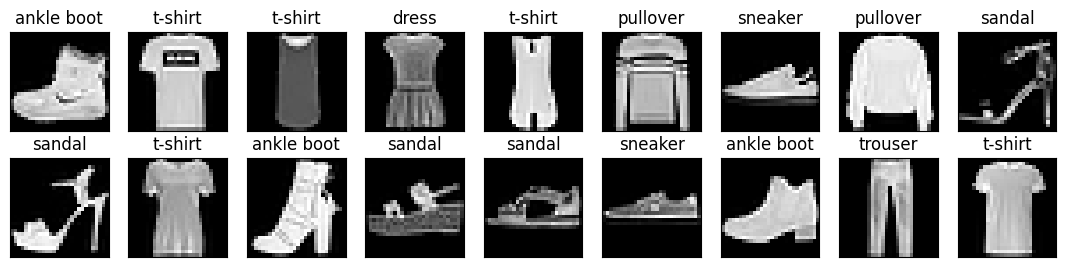

In [13]:
import os
import hashlib
import ssl
import urllib.request

import torch
import torchvision
from torch.utils import data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# 1. 关闭 SSL 验证（仅限本地开发环境）
ssl._create_default_https_context = ssl._create_unverified_context

# 2. GitHub Raw 地址与文件信息
BASE_URL = "https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion"
FILES = {
    "train-images-idx3-ubyte.gz": "8d4fb7e6c68d591d4c3dfef9ec88bf0d",
    "train-labels-idx1-ubyte.gz": "25c81989df183df01b3e8a0aad5dffbe",
    "t10k-images-idx3-ubyte.gz":  "bef4ecab320f06d8554ea6380940ec79",
    "t10k-labels-idx1-ubyte.gz":  "bb300cfdad3c16e7a12a480ee83cd310",
}
RAW_ROOT = "./data/FashionMNIST/raw"  # 注意：和 torchvision 一致，类名 + raw[web:43]

def _md5(path):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            md5.update(chunk)
    return md5.hexdigest()

def download_fashion_mnist_raw():
    """如果 raw 目录里缺文件就自动从 GitHub Raw 下载"""
    os.makedirs(RAW_ROOT, exist_ok=True)
    for fname, md5 in FILES.items():
        fpath = os.path.join(RAW_ROOT, fname)
        if os.path.exists(fpath) and _md5(fpath) == md5:
            continue
        url = f"{BASE_URL}/{fname}"
        print(f"Downloading {url} -> {fpath}")
        urllib.request.urlretrieve(url, fpath)
        if _md5(fpath) != md5:
            raise RuntimeError(f"MD5 mismatch for {fpath}")

# 3. 覆盖 torchvision 的资源配置，让它只负责解压和处理
datasets.FashionMNIST.mirrors = [""]  # 不再拼接 S3 前缀[web:43]
datasets.FashionMNIST.resources = [
    ("train-images-idx3-ubyte.gz", FILES["train-images-idx3-ubyte.gz"]),
    ("train-labels-idx1-ubyte.gz", FILES["train-labels-idx1-ubyte.gz"]),
    ("t10k-images-idx3-ubyte.gz",  FILES["t10k-images-idx3-ubyte.gz"]),
    ("t10k-labels-idx1-ubyte.gz",  FILES["t10k-labels-idx1-ubyte.gz"]),
]

# 4. 标签映射
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 5. 可视化
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.squeeze().numpy(), cmap="gray")
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

# 6. 数据加载：这里必须显式调用 download_fashion_mnist_raw()
def load_data_fashion_mnist(batch_size, resize=None):
    # 先确保 raw 目录有四个 .gz（自动联网下载）
    download_fashion_mnist_raw()

    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True  # 让它只做解压和处理[web:43]
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True
    )

    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=0)
    test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=0)
    return train_iter, test_iter

# 7. 主逻辑

train_iter, test_iter = load_data_fashion_mnist(batch_size=32)

for X, y in train_iter:
    print(f"输入张量形状：{X.shape}，数据类型：{X.dtype}")
    print(f"标签形状：{y.shape}，数据类型：{y.dtype}")
    break

X, y = next(iter(data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=transforms.ToTensor(), download=False
    ),
    batch_size=18
)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))


### 3.3 初始化模型参数
原始数据集中的每个样本都是 28X28 的图像。 
这里我们姑且展平每个图像，把它们看作长度为784的向量。 
在后面的章节中，我们将讨论能够利用图像空间结构的特征， 但现在我们暂时只把每个像素位置看作一个特征。

In [16]:
# 在softmax回归中，我们的输出与类别一样多。 因为我们的数据集有10个类别，所以网络输出维度为10
# 所以权重矩阵的形状为 (784, 10)，偏置向量的形状为 (10,)的行向量
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [18]:
# 通过Pytorch实现的话只需要在Sequential中添加一个Flatten层
from torch import nn
net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))
# PyTorch 的nn.Linear层有自己的默认权重初始化规则
# weight默认用「均匀分布」初始化，范围是 (-1/sqrt(in_features), 1/sqrt(in_features))
# 比如输入维度是 784，默认权重会在 (-1/√784≈-0.037, 1/√784≈0.037) 之间均匀分布。
# 而bias全部初始化为0

# 下面自定义的函数只对Linear层的权重做初始化
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights) # apply函数会递归地应用到net的所有子模块上，传入的参数是函数，函数会被应用到每个子模块上


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 3.4 定义 Softmax 操作
实现softmax由三个步骤组成：
- 对每个项求幂（使用exp）；
- 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
- 将每一行除以其规范化常数，确保结果的和为1。
举个例子：
```python
# 2个样本，每个样本3个特征
X = torch.tensor([[1.0, 2.0, 3.0],  # 样本1
                  [4.0, 5.0, 6.0]]) # 样本2

# 3个特征 → 4个类别的权重（特征数×类别数）
W = torch.tensor([[0.1, 0.2, 0.3, 0.4],  # 特征1对应4个类别的权重
                  [0.5, 0.6, 0.7, 0.8],  # 特征2对应4个类别的权重
                  [0.9, 1.0, 1.1, 1.2]]) # 特征3对应4个类别的权重

# 4个类别的偏置（和输出类别数一致）
b = torch.tensor([0.1, 0.2, 0.3, 0.4])
```
mynet(X)的核心是「把输入转成二维矩阵 → 矩阵乘法（特征 × 权重） → 加偏置」，最终得到每个样本对应每个类别的「原始得分（logits）」。
`W.shape[0]` 取 W 的第一维长度，也就是输入特征数 3
`reshape(-1, 3)` 中-1表示「自动计算这个维度的长度」，目的是把任意形状的输入（比如图片是 [2,28,28]）转成「样本数 × 特征数」的二维矩阵；3 表示特征数，也就是输入的每个样本有 3 个特征。
上面 X 原本就是[2,3]，reshape 后还是[2,3]

然后`torch.matmul`做矩阵乘法，[样本数, 特征数] × [特征数, 类别数] = [样本数, 类别数]，即 [2,3] × [3,4] = [2,4]，再加个偏置得到logits传给Softmax
`x_exp.sum (1, keepdim=True)`中的`1`表示按「行」求和（1 是维度索引，0 是列、1 是行），`keepdim=True`保持求和后的维度（否则会从 [2,4] 求和成 [2]，后续广播会出错）
```python
# x_exp
[[49.4025, 99.4843, 200.3369, 403.4288],
 [4470.1193, 22026.4648, 109574.6143, 544571.9849]]  # 维度[2,4]
# partition
[[403.4288],
 [544571.9849]]  # 维度[2,1]
# partition w/o keepdim=True
[403.4288, 544571.9849]  # 维度[2]
```
`x_exp /partition`就是广播除法了，[2,4]的x_exp除以[2,1]的partition，广播机制会让「每行的每个元素 ÷ 该行的和」，最终每行的和为 1（概率分布）

In [20]:
def softmax(X):
    x_exp = torch.exp(X)
    partition = x_exp.sum(1, keepdim=True) # 对每一行求和，得到每个样本的规范化常数
    return x_exp / partition               # 广播机制，每个元素都除以其所在行的规范化常数

def mynet(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

手动 softmax 是 softmax(X) = exp(X)/sum(exp(X), 1)，但如果X里有极大值 / 极小值。exp(1000)直接溢出；exp(-1000)直接下溢。

为了数值稳定性，我们通常会减去X的最大值，即 softmax(X) = exp(X - max(X))/sum(exp(X - max(X)), 1)。

每个o_j减max(o_k)等价于给分子分母都乘以exp(-max(o_k))，分子分母同时乘常数，结果不变

减 max 后，还是可能有下溢（比如o_j - max(o_k) = -1000，exp(-1000)≈0）。但交叉熵损失需要计算-sum(y_true * log(softmax(o)))

所以把log(softmax(o))直接展开计算，比如o_j - max(o_k) = -1000，如果单独算分子再算log的话exp(o_j - max(o_k))会变成 0，但把log&exp合并后不需要计算exp(-1000)，直接用o_j - max(o_k)本身参与计算

这个手动改起来太麻烦，不过Pytorch的`CrossEntropyLoss`已经内置了这两个操作:

`原始得分o → 减当前样本的max(o) → 直接用 (o_j - max(o)) - log(sum(exp(o_k - max(o)))) 计算 log(softmax) → 交叉熵`
### 3.5 损失函数

In [21]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

    # y_hat[range(len(y_hat)), y] 是 y_hat 中对应 y 中每个元素的预测值
    # 比如 y_hat = [[0.1, 0.3, 0.6], [0.7, 0.2, 0.1]]，y = [0, 2]
    # y_hat 中每个样本的预测概率分别是 [0.1, 0.3, 0.6] 和 [0.7, 0.2, 0.1]
    # y = [0, 2] 告诉我们第一个样本属于类别 0，第二个样本属于类别 2
    # 则 y_hat[range(len(y_hat)), y] = [0.1, 0.1]
    # 这个切片操作，是取出 y_hat 中每个样本对应 y 中元素的预测概率
    # 比如 y_hat[0, y[0]] = 0.1，y_hat[1, y[1]] = 0.1
    # 再对每个元素取 log 并取负号，就是交叉熵损失


In [22]:
loss = nn.CrossEntropyLoss(reduction='none') # reduction='none' 表示不进行平均，返回每个样本的损失

### 3.6 优化器


In [ ]:
# def sgd(params, lr, batch_size):
# 前面已经定义过了

In [27]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1) # 依旧小批量随机梯度下降

### 3.7 训练
我们需要添加几个辅助函数，然后编写训练循环：

In [28]:
USE_PYTORCH = False  # ← 切换这个变量来选择实现方式

# ==================== 3.7 训练 ====================

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch(net, train_iter, loss_fn, trainer, batch_size):
    """训练模型一个迭代周期"""
    if USE_PYTORCH:
        # PyTorch版本
        net.train()
        metric = Accumulator(3)  # 训练损失总和，训练准确度总和，样本数
        
        for X, y in train_iter:
            # 前向传播
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            
            # 反向传播
            trainer.zero_grad()
            l.mean().backward()
            trainer.step()
            
            # 统计
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        
        return metric[0] / metric[2], metric[1] / metric[2]
    
    else:
        # 手动实现版本
        metric = Accumulator(3)  # 训练损失总和，训练准确度总和，样本数
        W, b = trainer  # 解包参数
        
        for X, y in train_iter:
            # 前向传播
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            
            # 反向传播
            l.sum().backward()
            sgd([W, b], lr, batch_size)
            
            # 统计
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        
        return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):
    """评估模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
    
    metric = Accumulator(2)  # 正确预测数，预测总数
    
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    
    if isinstance(net, torch.nn.Module):
        net.train()  # 改回训练模式
    
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, loss_fn, trainer, num_epochs, batch_size):
    """完整的训练过程"""
    print('开始训练...')
    
    # 初始化动画
    animator_data = {
        'train_loss': [], 'train_acc': [], 'test_acc': [],
        'epochs': list(range(1, num_epochs + 1))
    }
    
    for epoch in range(num_epochs):
        # 训练一个epoch
        train_loss, train_acc = train_epoch(net, train_iter, loss_fn, trainer, batch_size)
        
        # 在测试集上评估
        test_acc = evaluate_accuracy(net, test_iter)
        
        # 记录数据
        animator_data['train_loss'].append(train_loss)
        animator_data['train_acc'].append(train_acc)
        animator_data['test_acc'].append(test_acc)
        
        # 打印进度
        print(f'epoch {epoch + 1}, '
              f'训练损失: {train_loss:.4f}, '
              f'训练精度: {train_acc:.3f}, '
              f'测试精度: {test_acc:.3f}')
    
    # 绘制训练曲线
    plt.figure(figsize=(12, 4))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(animator_data['epochs'], animator_data['train_loss'], 'b-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    
    # 精度曲线
    plt.subplot(1, 2, 2)
    plt.plot(animator_data['epochs'], animator_data['train_acc'], 'r-', label='train')
    plt.plot(animator_data['epochs'], animator_data['test_acc'], 'g-', label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return animator_data

### 3.8 预测

In [30]:
def predict(net, test_iter, n=6):
    """预测标签"""
    # 获取一批数据
    for X, y in test_iter:
        break
    
    # 获取真实标签和预测标签
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    
    # 创建标题
    titles = [f'{true}\n{pred}' for true, pred in zip(trues, preds)]
    
    # 显示图像
    show_images(
        X[0:n].reshape((n, 28, 28)), 
        1, n, 
        titles=titles[0:n]
    )

def predict_batch(net, test_iter, batch_idx=0, n=10):
    """预测指定批次的数据"""
    # 获取指定批次的数据
    for i, (X, y) in enumerate(test_iter):
        if i == batch_idx:
            break
    
    # 预测
    with torch.no_grad():
        y_hat = net(X[:n])
        y_pred = y_hat.argmax(axis=1)
    
    # 获取标签文本
    true_labels = get_fashion_mnist_labels(y[:n])
    pred_labels = get_fashion_mnist_labels(y_pred)
    
    # 显示
    print(f"批次 {batch_idx} 的前 {n} 个预测:")
    print("-" * 40)
    for i in range(n):
        correct = "✓" if true_labels[i] == pred_labels[i] else "✗"
        print(f"样本 {i+1}: 真实={true_labels[i]:<12} 预测={pred_labels[i]:<12} {correct}")
    
    # 可视化
    titles = [f'真:{true}\n预:{pred}' for true, pred in zip(true_labels, pred_labels)]
    show_images(
        X[:n].reshape(n, 28, 28),
        2, (n + 1) // 2,
        titles=titles
    )
    
    # 计算该批次的准确率
    correct = sum(1 for i in range(n) if true_labels[i] == pred_labels[i])
    print(f"\n该批次前{n}个样本的准确率: {correct}/{n} ({correct/n:.1%})")

def predict_single(net, test_dataset, idx=0):
    """预测单个样本"""
    # 获取单个样本
    X, y = test_dataset[idx]
    
    # 添加批次维度
    X_batch = X.unsqueeze(0)
    
    # 预测
    with torch.no_grad():
        y_hat = net(X_batch)
        prob = torch.softmax(y_hat, dim=1) if USE_PYTORCH else y_hat
        y_pred = prob.argmax(axis=1).item()
        confidence = prob.max().item()
    
    # 获取标签
    true_label = get_fashion_mnist_labels([y])[0]
    pred_label = get_fashion_mnist_labels([y_pred])[0]
    
    # 显示
    print(f"样本 {idx} 的预测:")
    print(f"  真实标签: {true_label} (类别 {y})")
    print(f"  预测标签: {pred_label} (类别 {y_pred})")
    print(f"  置信度: {confidence:.2%}")
    print(f"  是否正确: {'✓' if y == y_pred else '✗'}")
    
    # 显示图像
    show_images(
        X.reshape(1, 28, 28),
        1, 1,
        titles=[f'真:{true_label}\n预:{pred_label}\n置信:{confidence:.1%}']
    )
def evaluate_model(net, test_iter):
    """全面评估模型性能"""
    print("正在评估模型性能...")
    
    # 1. 计算整体准确率
    overall_acc = evaluate_accuracy(net, test_iter)
    print(f"1. 整体准确率: {overall_acc:.3f}")
    
    # 2. 计算每个类别的准确率
    print("\n2. 按类别统计:")
    print("-" * 50)
    
    # 初始化每个类别的统计
    class_correct = [0] * 10
    class_total = [0] * 10
    class_names = get_fashion_mnist_labels(list(range(10)))
    
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = net(X)
            predictions = y_hat.argmax(axis=1)
            
            # 统计每个类别
            for i in range(len(y)):
                label = y[i].item()
                class_total[label] += 1
                if predictions[i].item() == label:
                    class_correct[label] += 1
    
    # 打印每个类别的准确率
    for i in range(10):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"   {class_names[i]:<12}: {acc:.3f} ({class_correct[i]}/{class_total[i]})")
    
    # 3. 计算混淆矩阵（简化版）
    print("\n3. 常见错误分析（混淆矩阵的前5个最多错误）:")
    print("-" * 50)
    
    # 收集错误
    error_counts = {}
    
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = net(X)
            predictions = y_hat.argmax(axis=1)
            
            for i in range(len(y)):
                true_label = y[i].item()
                pred_label = predictions[i].item()
                
                if true_label != pred_label:
                    key = (true_label, pred_label)
                    error_counts[key] = error_counts.get(key, 0) + 1
    
    # 按错误次数排序并显示前5个
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    
    for (true_idx, pred_idx), count in sorted_errors:
        true_name = get_fashion_mnist_labels([true_idx])[0]
        pred_name = get_fashion_mnist_labels([pred_idx])[0]
        print(f"   {true_name:<12} → {pred_name:<12}: {count}次")
    
    # 4. 计算平均置信度
    print("\n4. 置信度分析:")
    print("-" * 50)
    
    total_confidence = 0
    correct_confidence = 0
    wrong_confidence = 0
    correct_count = 0
    wrong_count = 0
    
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = net(X)
            
            # 获取概率和预测
            if USE_PYTORCH:
                probs = torch.softmax(y_hat, dim=1)
            else:
                probs = y_hat
            
            predictions = probs.argmax(axis=1)
            confidences = probs.max(axis=1).values
            
            for i in range(len(y)):
                confidence = confidences[i].item()
                total_confidence += confidence
                
                if predictions[i].item() == y[i].item():
                    correct_confidence += confidence
                    correct_count += 1
                else:
                    wrong_confidence += confidence
                    wrong_count += 1
    
    avg_confidence = total_confidence / (correct_count + wrong_count)
    avg_correct_confidence = correct_confidence / correct_count if correct_count > 0 else 0
    avg_wrong_confidence = wrong_confidence / wrong_count if wrong_count > 0 else 0
    
    print(f"   平均置信度: {avg_confidence:.3f}")
    print(f"   正确预测的平均置信度: {avg_correct_confidence:.3f}")
    print(f"   错误预测的平均置信度: {avg_wrong_confidence:.3f}")
    
    # 5. 返回评估结果
    evaluation_results = {
        'overall_accuracy': overall_acc,
        'class_accuracies': [class_correct[i]/class_total[i] for i in range(10)],
        'common_errors': sorted_errors,
        'confidence_stats': {
            'avg': avg_confidence,
            'avg_correct': avg_correct_confidence,
            'avg_wrong': avg_wrong_confidence
        }
    }
    
    return evaluation_results

def visualize_predictions(net, test_iter, n_samples=20):
    """可视化预测结果，正确和错误的样本都显示"""
    print(f"\n可视化 {n_samples} 个样本的预测结果:")
    print("=" * 60)
    
    # 收集样本
    all_samples = []
    
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = net(X)
            predictions = y_hat.argmax(axis=1)
            
            for i in range(len(y)):
                all_samples.append({
                    'image': X[i],
                    'true_label': y[i].item(),
                    'pred_label': predictions[i].item(),
                    'correct': predictions[i].item() == y[i].item()
                })
            
            if len(all_samples) >= n_samples:
                break
    
    # 分为正确和错误的预测
    correct_samples = [s for s in all_samples if s['correct']]
    wrong_samples = [s for s in all_samples if not s['correct']]
    
    # 显示正确预测的样本
    print(f"正确预测的样本 ({len(correct_samples)}个):")
    if correct_samples:
        images = [s['image'] for s in correct_samples[:min(10, len(correct_samples))]]
        titles = []
        
        for s in correct_samples[:min(10, len(correct_samples))]:
            true_name = get_fashion_mnist_labels([s['true_label']])[0]
            pred_name = get_fashion_mnist_labels([s['pred_label']])[0]
            titles.append(f'真:{true_name}\n预:{pred_name}')
        
        n = len(images)
        show_images(
            torch.stack(images).reshape(n, 28, 28),
            1, n,
            titles=titles
        )
    
    # 显示错误预测的样本
    print(f"\n错误预测的样本 ({len(wrong_samples)}个):")
    if wrong_samples:
        images = [s['image'] for s in wrong_samples[:min(10, len(wrong_samples))]]
        titles = []
        
        for s in wrong_samples[:min(10, len(wrong_samples))]:
            true_name = get_fashion_mnist_labels([s['true_label']])[0]
            pred_name = get_fashion_mnist_labels([s['pred_label']])[0]
            titles.append(f'真:{true_name}\n预:{pred_name}')
        
        n = len(images)
        show_images(
            torch.stack(images).reshape(n, 28, 28),
            1, n,
            titles=titles
        )
    
    return correct_samples, wrong_samples

最后开始训练分类任务。

In [32]:
print(f"开始训练 Softmax 回归模型")
print(f"实现方式: {'PyTorch' if USE_PYTORCH else '手动实现'}")
print(f"批量大小: {batch_size}, 学习率: {lr}, 训练轮数: {num_epochs}")
print("=" * 60)

# 训练
if USE_PYTORCH:
    trainer_obj = trainer  # PyTorch的优化器对象
else:
    trainer_obj = trainer  # 手动实现的参数元组 (W, b)

training_history = train(
    net, train_iter, test_iter, loss, 
    trainer_obj, num_epochs, batch_size
)

print(f"\n训练完成!")
print(f"最终训练精度: {training_history['train_acc'][-1]:.3f}")
print(f"最终测试精度: {training_history['test_acc'][-1]:.3f}")

# 进行预测
print("\n" + "=" * 60)
print("进行预测演示")
print("=" * 60)

# 预测一批数据
predict_batch(net, test_iter, batch_idx=0, n=10)


# 可视化预测结果
correct_samples, wrong_samples = visualize_predictions(net, test_iter, n_samples=20)

print(f"\n总结:")
print(f"- 总准确率: {evaluation_results['overall_accuracy']:.3f}")
print(f"- 正确预测样本数: {len(correct_samples)}")
print(f"- 错误预测样本数: {len(wrong_samples)}")
print(f"- 错误率: {len(wrong_samples)/(len(correct_samples)+len(wrong_samples)):.3f}")


开始训练 Softmax 回归模型
实现方式: 手动实现
批量大小: 256, 学习率: 0.1, 训练轮数: 10
开始训练...


TypeError: cannot unpack non-iterable SGD object